---
# Create ESMF mesh file for running WW3 for CESM3 LGM
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Tools used
  - [pop_tools](https://pop-tools.readthedocs.io/en/latest/) to get gx3v7 grid
  - xesmf to regrid MOM6 LGM topo into gx3v7
  - UXarray for visualization of the mesh file
---

In [1]:
import datetime

import numpy as np
import xarray as xr
import uxarray as ux
import xesmf

import pop_tools

import warnings
warnings.filterwarnings('ignore')

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


---
## Input files
- WW3 mesh file for preindustrial, elementMask of which will be updated
- LGM topography file for MOM6 to get an LGM land-sea mask
- Standard gx3v7 grid for regridding

In [2]:
ww3_mesh_pre = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/wgx3v7_2301208_ESMFmesh.nc'
ds_mesh_pre = xr.open_dataset(ww3_mesh_pre)
ds_mesh_pre

<xarray.Dataset>
Dimensions:         (nodeCount: 11700, coordDim: 2, elementCount: 11600,
                     maxNodePElement: 4)
Dimensions without coordinates: nodeCount, coordDim, elementCount,
                                maxNodePElement
Data variables:
    nodeCoords      (nodeCount, coordDim) float64 ...
    elementConn     (elementCount, maxNodePElement) float64 ...
    numElementConn  (elementCount) int8 ...
    centerCoords    (elementCount, coordDim) float64 ...
    elementArea     (elementCount) float64 ...
    elementMask     (elementCount) int32 ...
Attributes:
    gridType:       unstructured mesh
    version:        0.9
    inputFile:      gx3v7_120309.nc
    timeGenerated:  Mo

In [3]:
mom_topo_lgm = '/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2/ocean_topo_tx2_3v2_240501_21ka_250108.nc'
ds_mom_lgm = xr.open_dataset(mom_topo_lgm).rename({'y': 'lat', 'x': 'lon'})
ds_mom_lgm

<xarray.Dataset>
Dimensions:  (ny: 480, nx: 540)
Dimensions without coordinates: ny, nx
Data variables:
    lat      (ny, nx) float64 ...
    lon      (ny, nx) float64 ...
    mask     (ny, nx) int32 ...
    depth    (ny, nx) float32 ...
Attributes:
    date_created:  2025-01-08T14:23:32.689354
    title:         LGM bathymetry file for MOM6 by Jiang Zhu (jiangzhu@ucar.e...
    min_depth:     2.5
    max_depth:     8008.71923828125

In [4]:
ds_gx3 = pop_tools.get_grid('POP_gx3v7')
ds_gx3['lat'] = ds_gx3.TLAT
ds_gx3['lon'] = ds_gx3.TLONG
ds_gx3

<xarray.Dataset>
Dimensions:      (nlat: 116, nlon: 100, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG        (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
    ULAT         (nlat, nlon) float64 -78.73 -78.73 -78.73 ... 68.49 68.42 68.4
    ULONG        (nlat, nlon) float64 325.1 328.7 332.3 ... 318.7 320.1 321.5
    DXT          (nlat, nlon) float64 6.842e+06 6.828e+06 ... 6.129e+06
    DYT          (nlat, nlon) float64 1.686e+07 1.686e+07 ... 4.524e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.318e+14 1.318e+14 ... 6.256e+13 6.27e+13
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    lat          (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    lon          (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
Attributes:
    lateral_dims:       [116, 100]
    vertical_dims:      60
    vert_grid_file:     gx3v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx3v7/grid/horiz_grid_20030806.ieeer8
    topography_fname:   inputdata/ocn/pop/gx3v7/grid/topography_20100105.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx3v7/grid/region_mask_20090831.ieeei4
    type:               dipole
    title:              POP_gx3v7 grid

---
## Output mesh file
- We only need to update the land-sea mask, `elementMask`

In [5]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2'
ww3_mesh_lgm = f"{work_dir}/wgx3v7_2301208_ESMFmesh_21ka_{today}.nc"
print(ww3_mesh_lgm)

250127
/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2/wgx3v7_2301208_ESMFmesh_21ka_250127.nc


---
## Step 1: Use LGM topo to create a land-sea mask to update that in the preindustrial mesh

### Regrid MOM6 `depth` to gx3v7

In [6]:
%%time

regridder = xesmf.Regridder(
    ds_mom_lgm,
    ds_gx3,
    method="bilinear",
    periodic=True)

depth_lgm = regridder(ds_mom_lgm.depth)
depth_lgm

CPU times: user 3.6 s, sys: 105 ms, total: 3.7 s
Wall time: 7.77 s


<xarray.DataArray (nlat: 116, nlon: 100)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: nlat, nlon
Attributes:
    regrid_method:  bilinear

### Update `elementMask` in the preindustrial mesh file

In [7]:
mask_pre = ds_mesh_pre.elementMask
mask_lgm = np.where(depth_lgm > 0, 1, 0).flatten().astype(np.int32)

ds_mesh_lgm = ds_mesh_pre.copy(deep=True)
ds_mesh_lgm.elementMask.data = np.where(mask_lgm == 0, 0, mask_pre)

ds_mesh_lgm.attrs['Title']  = 'ESMF mesh for running WW3 in gx3v7 for CESM3 LGM'
ds_mesh_lgm.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_mesh_lgm.attrs["Source_topo_file"] = mom_topo_lgm
ds_mesh_lgm.attrs['Script'] = '03.create_ww3_mesh.ipynb'
ds_mesh_lgm.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm3'
ds_mesh_lgm.attrs["Date_created"] = datetime.datetime.now().isoformat()

ds_mesh_lgm.to_netcdf(ww3_mesh_lgm, format="NETCDF3_64BIT")

---
## Step 2: Use UXarray to make plot to check results

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
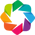

:Layout
   .Image.I   :Image   [x,y]   (x_y elementMask)
   .Image.II  :Image   [x,y]   (x_y elementMask)
   .Image.III :Image   [x,y]   (x_y elementMask)

In [8]:
ds_mesh_pre = ux.open_dataset(ww3_mesh_pre, ww3_mesh_pre)
ds_mesh_lgm = ux.open_dataset(ww3_mesh_lgm, ww3_mesh_lgm)

p1 = ds_mesh_pre.elementMask.plot().opts(
    height=400, width=600, title='mask in PI mesh')

p2 = ds_mesh_lgm.elementMask.plot().opts(
    height=400, width=600, title='mask in LGM mesh')

p3 = (ds_mesh_lgm.elementMask - ds_mesh_pre.elementMask).plot(
    cmap='BuRd_r').opts(height=400, width=600, title='diff')

p = p1 + p2 + p3
p